In [1]:
%matplotlib notebook
from datetime import datetime, timedelta
import glob
from eigsep_corr import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates

In [2]:
DATA_DIR = "../../data_2024"
#files = sorted(glob.glob(f"{DATA_DIR}/20240722_1[4-8]*"))  # 2pm to 2:30 pacific time
files = sorted(glob.glob(f"{DATA_DIR}/2024072*"))  # arrived on the 20th
# corrupted files
files = np.array(files)
print(len(files))
hdr = io.read_header(files[0])
print(io.read_header(files[0]).keys())
freqs = np.linspace(0, hdr['sample_rate'] / 2, hdr['nchan'], endpoint=False)
hdr, data = io.read_file(files[0], header=hdr)
print(data.keys())
print(data['0'].shape)
acc_cnt = []
times = []
for i, f in enumerate(files):
    try:
        hdr = io.read_header(f)
    except:
        print(f)
        files = np.delete(files, i)
        continue
    acc_cnt.append(hdr['acc_cnt'])
    times.append(hdr['times'])
acc_cnt = np.concatenate(acc_cnt)
times = np.concatenate(times)

1155
dict_keys(['dtype', 'infochan', 'nchan', 'acc_bins', 'fpg_file', 'fpg_version', 'sample_rate', 'gain', 'corr_acc_len', 'corr_scalar', 'pol01_delay', 'pam_atten', 'fft_shift', 'pairs', 'acc_cnt', 'sync_time', 'pol23_delay', 'pol45_delay', 'header_size', 'data_start', 'filename', 'filesize', 'nspec', 'freqs', 'dfreq', 'inttime', 'times'])
dict_keys(['0', '1', '2', '3', '4', '5', '02', '04', '24', '13', '15', '35'])
(60, 2, 1024, 1)
../../data_2024/20240721_174736.eig
../../data_2024/20240721_175617.eig
../../data_2024/20240721_180443.eig
../../data_2024/20240721_180635.eig
../../data_2024/20240722_172532.eig


[  15  361  426  438  443  444  445  446  457  473  481  485  608  877
  921 1019 1113 1116]


<IPython.core.display.Javascript object>


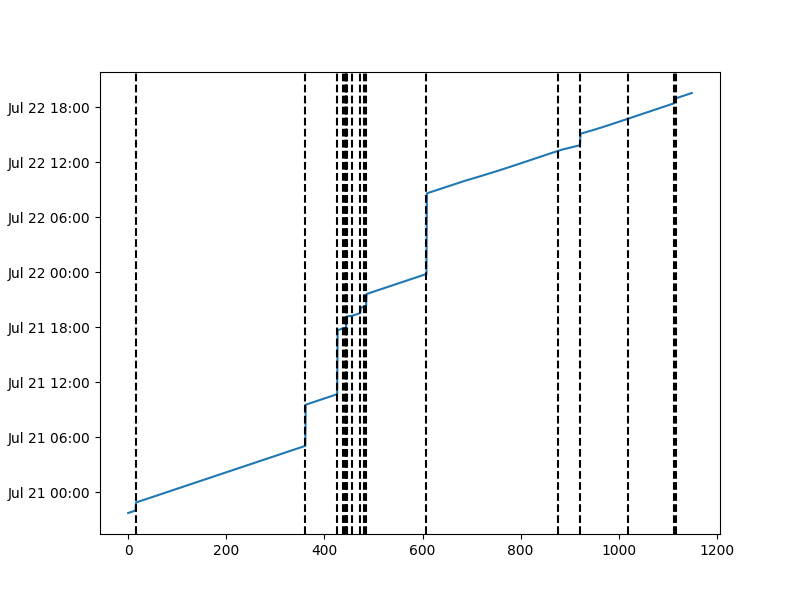

In [3]:
def fname2ts(f):
    t = f[-len("20231014_202203.eig"):-4]
    y = t[:4]
    mo = t[4:6]
    d = t[6:8]
    h = t[9:11]
    mi = t[11:13]
    s = t[13:15]
    dt = datetime.fromisoformat(f"{y}-{mo}-{d} {h}:{mi}:{s}")
    # add one hour to convert from pacific time to local time
    dt = dt + timedelta(hours=1)
    return dt

ftime = np.array([fname2ts(f) for f in files])
timestamps = [ft.timestamp() for ft in ftime]
ix = np.argsort(timestamps)
ftime = ftime[ix]
files = files[ix]

# observing stops when two files are far apart
breaks = np.argwhere(np.diff(timestamps) > np.median(np.diff(timestamps)+1))[:, 0]
print(breaks)

plt.figure(figsize=(8, 6))
plt.plot(ftime)
for b in breaks:
    plt.axvline(b, ls="--", c="k")
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
plt.yticks(rotation=0)
plt.ylabel("Local Time")
plt.show()

The plot above shows the observing windows.

Night 1, July 20/21: box on the ground, vivaldis on the ground
Day 2, July 21 09:30 - 10:40: resumed observations, turned off due to heat
Night 2, July 22/23: box suspended
Day 3, July 23: resumed at 08:30, North Vivaldi north pol off due to broken fiber. Rotated box ~09:11 - 11:45. Overheating shorly before 2pm, was working on lowering box at this time. Started raising Vivaldi around 3pm.

In [4]:
observing_windows = {
    "night1": (15, 361),  # sat to sun (all ant on ground)
    "sunday": (361, 426),  # sun morning (all ant on ground)
    "night2": (485, 608),  # sun to mon (box raised)
    "monday_am": (608, 921),  # monday morning/day (rolls + lowering box)
    "monday_pm": (921, 1113),  # raised vivaldi
}

auto = [f"{i}" for i in range(6)]
cross = [f"{i}{i+2}" for i in range(4)] + ["04", "15"]

def load_data(obs_window, pairs=auto+cross):
    mn, mx = observing_windows[obs_window]
    data = {}
    for f in files[mn:mx]:
        hdr, dat = io.read_file(f)
        for k, d in dat.items():
            if k not in pairs:
                continue
            if len(k) == 1:
                d.dtype = io.build_dtype(np.uint32, '>')
                d = d[..., 0]  # only real part
            else:
                d = d[..., 0] + 1j * d[..., 1]  # complex number
            data[k] = data.get(k, []) + [d]
    for k, v in data.items():
        data[k] = np.concatenate(v, axis=0)
    tmin, tmax = ftime[mn], ftime[mx]
    return data, (tmin, tmax)

<IPython.core.display.Javascript object>


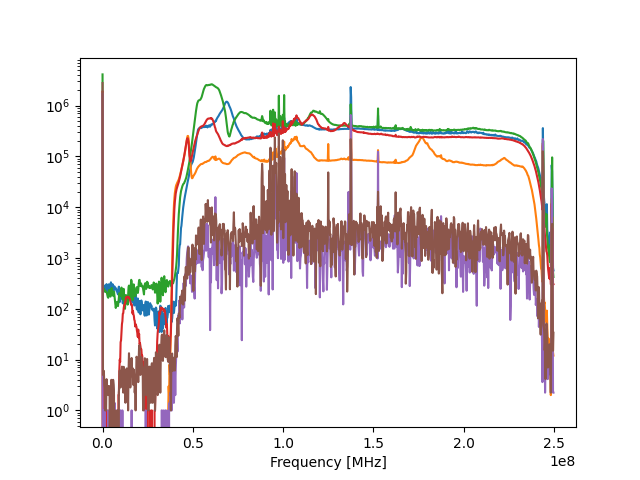

<IPython.core.display.Javascript object>


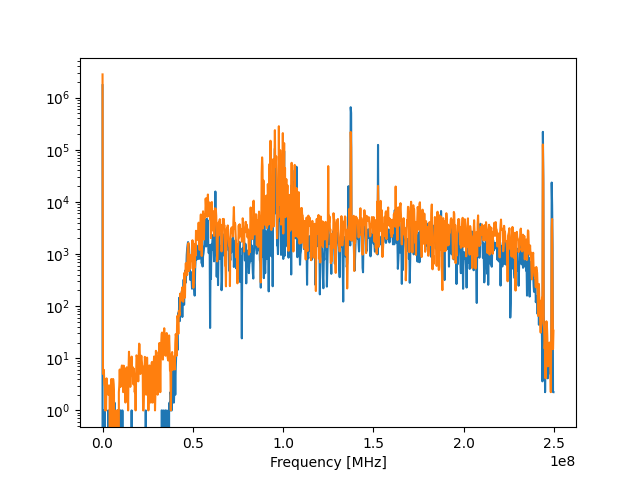

In [5]:
n1, time1 = load_data("night1")

ix = 8080

plt.figure()
plt.semilogy(freqs, n1["0"][:, 0][ix])
plt.semilogy(freqs, n1["2"][:, 0][ix])
#plt.semilogy(freq, n1["4"][:, 0][ix])
plt.semilogy(freqs, n1["1"][:, 0][ix])
plt.semilogy(freqs, n1["3"][:, 0][ix])
#plt.semilogy(freq, n1["5"][:, 0][ix])
plt.semilogy(freqs, np.abs(n1["02"][:, 0])[ix])
plt.semilogy(freqs, np.abs(n1["13"][:, 0])[ix])
plt.xlabel("Frequency [MHz]")
#plt.savefig("sample_spectrum.pdf", bbox_inches="tight")
plt.show()

plt.figure()
#plt.semilogy(freq, np.abs(data["24"][:, 0, :, 0]+1j*data["24"][:, 0, :, 1])[ix])
plt.semilogy(freqs, np.abs(n1["02"][:, 0])[ix])
plt.semilogy(freqs, np.abs(n1["13"][:, 0])[ix])
#plt.semilogy(freq, np.abs(data["35"][:, 0, :, 0]+1j*data["35"][:, 0, :, 1])[ix])
#plt.semilogy(freq, np.abs(data["15"][:, 0, :, 0]+1j*data["15"][:, 0, :, 1])[ix])
plt.xlabel("Frequency [MHz]")
plt.show()

In [12]:
def plot_waterfall(data, extent, title=None):
    fig, axs = plt.subplots(figsize=(8, 6), nrows=2, ncols=3, sharex=True, sharey=True, constrained_layout=True)
    auto_ln = colors.LogNorm(vmin=1e2, vmax=1e7)
    cross_ln = colors.LogNorm(vmin=1e-3, vmax=1e0)
    kwargs = {"aspect": "auto", "cmap": "plasma", "extent": extent, "interpolation": "none"}
    for i, k in enumerate(["24", "35"]):
        for j in range(2):
            d = np.abs(data[k[j]][:, 0])
            axs[i, 2*j].imshow(d, norm=auto_ln, **kwargs)
        norm = np.sqrt(data[k[0]]**2 + data[k[1]]**2)[:, 0]
        axs[i, 1].imshow(np.abs(data[k][:, 0])/norm, norm=cross_ln, **kwargs)
    axs[0, 0].yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    fig.supxlabel("Frequency [MHz]")
    fig.supylabel("Local Time")
    #plt.savefig("plots/waterfall_july21.p", bbox_inches="tight")
    if title:
        plt.suptitle(title)
    plt.show()

<IPython.core.display.Javascript object>


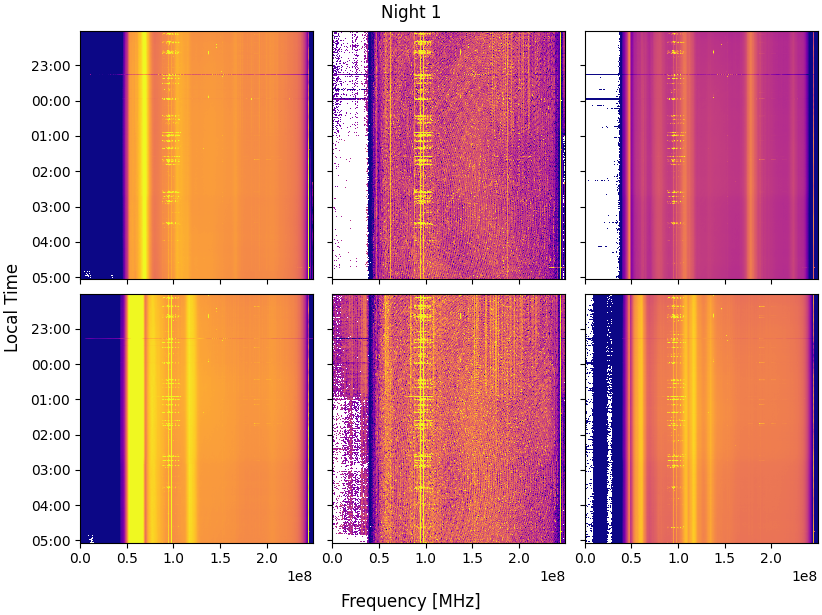

/tmp/ipykernel_94095/2879565739.py:11: RuntimeWarning: invalid value encountered in divide
  axs[i, 1].imshow(np.abs(data[k][:, 0])/norm, norm=cross_ln, **kwargs)


In [17]:
extent = [freqs.min()/1e6, freqs.max()/1e6, time1[1], time1[0]]
plot_waterfall(n1, extent, title="Night 1")

<IPython.core.display.Javascript object>


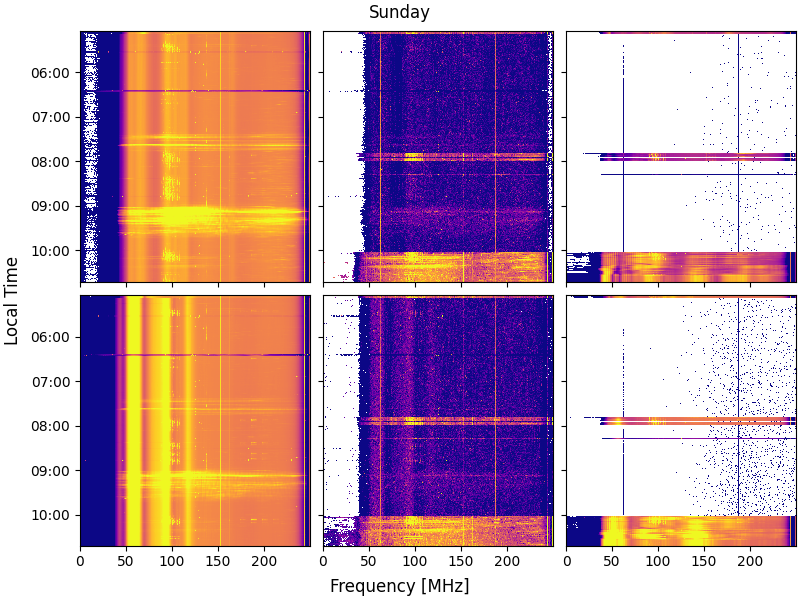

/tmp/ipykernel_94095/2879565739.py:11: RuntimeWarning: divide by zero encountered in divide
  axs[i, 1].imshow(np.abs(data[k][:, 0])/norm, norm=cross_ln, **kwargs)
/tmp/ipykernel_94095/2879565739.py:11: RuntimeWarning: invalid value encountered in divide
  axs[i, 1].imshow(np.abs(data[k][:, 0])/norm, norm=cross_ln, **kwargs)


In [20]:
sun, time_sun = load_data("sunday")

extent = [freqs.min()/1e6, freqs.max()/1e6, time_sun[1], time_sun[0]]
plot_waterfall(sun, extent, title="Sunday")

<IPython.core.display.Javascript object>


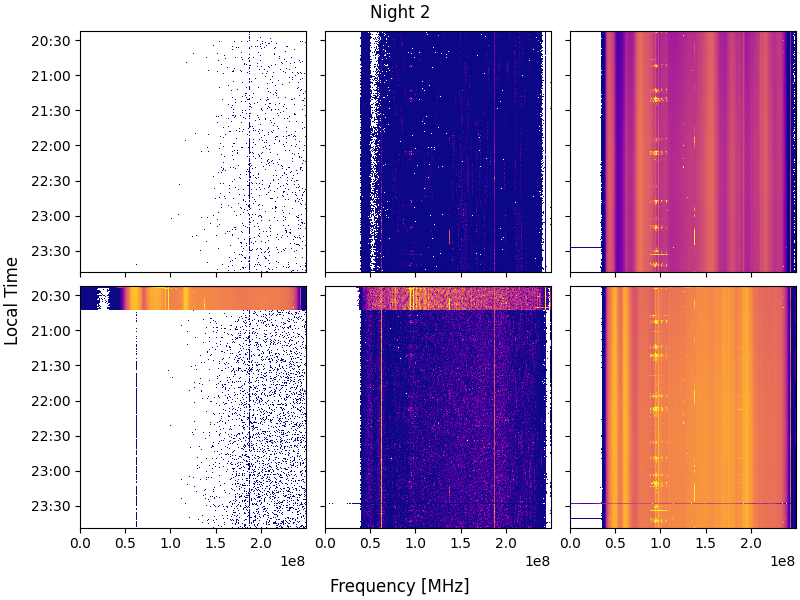

/tmp/ipykernel_94095/2879565739.py:11: RuntimeWarning: divide by zero encountered in divide
  axs[i, 1].imshow(np.abs(data[k][:, 0])/norm, norm=cross_ln, **kwargs)
/tmp/ipykernel_94095/2879565739.py:11: RuntimeWarning: invalid value encountered in divide
  axs[i, 1].imshow(np.abs(data[k][:, 0])/norm, norm=cross_ln, **kwargs)


In [18]:
n2, time2 = load_data("night2")
extent = [freqs.min()/1e6, freqs.max()/1e6, time2[1], time2[0]]
plot_waterfall(n2, extent, title="Night 2")

<IPython.core.display.Javascript object>


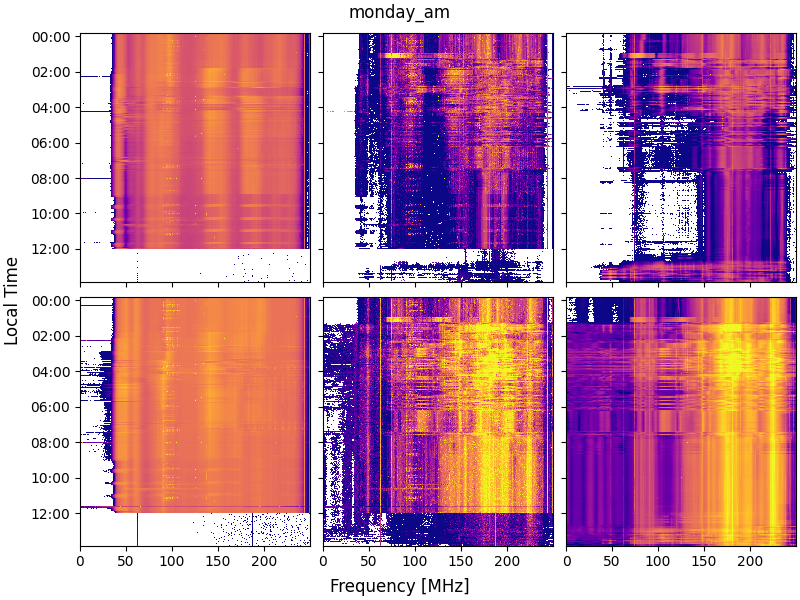

/tmp/ipykernel_95425/967968692.py:11: RuntimeWarning: divide by zero encountered in divide
  axs[i, 1].imshow(np.abs(data[k][:, 0])/norm, norm=cross_ln, **kwargs)
/tmp/ipykernel_95425/967968692.py:11: RuntimeWarning: invalid value encountered in divide
  axs[i, 1].imshow(np.abs(data[k][:, 0])/norm, norm=cross_ln, **kwargs)


In [13]:
#monam, tam = load_data("monday_am")

extent = [freqs.min()/1e6, freqs.max()/1e6, tam[1], tam[0]]
plot_waterfall(monam, extent, title="monday_am")

<IPython.core.display.Javascript object>


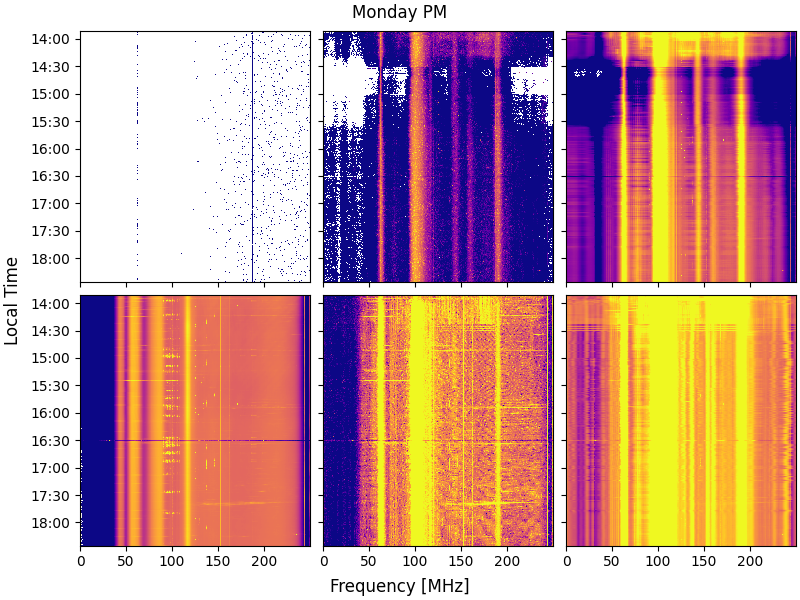

/tmp/ipykernel_95425/2879565739.py:11: RuntimeWarning: divide by zero encountered in divide
  axs[i, 1].imshow(np.abs(data[k][:, 0])/norm, norm=cross_ln, **kwargs)
/tmp/ipykernel_95425/2879565739.py:11: RuntimeWarning: invalid value encountered in divide
  axs[i, 1].imshow(np.abs(data[k][:, 0])/norm, norm=cross_ln, **kwargs)


In [6]:
monpm, tpm = load_data("monday_pm")

extent = [freqs.min()/1e6, freqs.max()/1e6, tpm[1], tpm[0]]
plot_waterfall(monpm, extent, title="Monday PM")

<IPython.core.display.Javascript object>


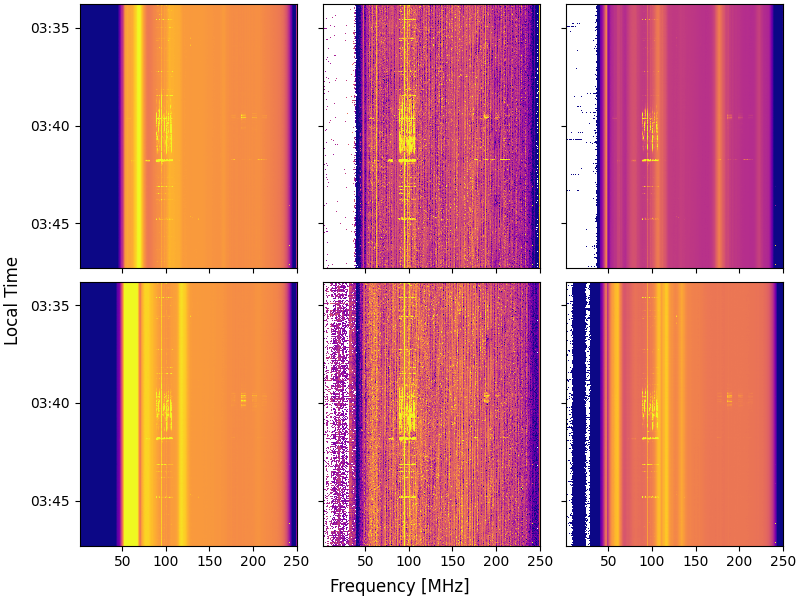

/tmp/ipykernel_65233/3898631817.py:10: RuntimeWarning: invalid value encountered in divide
  axs[i, 1].imshow(np.abs(data[k][:, 0, :, 0]+1j*data[k][:, 0, :, 1])/norm, norm=cross_ln, **kwargs)


In [17]:
fig, axs = plt.subplots(figsize=(8, 6), nrows=2, ncols=3, sharex=True, sharey=True, constrained_layout=True)
auto_ln = colors.LogNorm(vmin=1e4, vmax=1e6)
cross_ln = colors.LogNorm(vmin=1e-3, vmax=1e0)
kwargs = {"aspect": "auto", "cmap": "plasma", "extent": extent, "interpolation": "none"}
for i, k in enumerate(["02", "13"]):
    for j in range(2):
        d = np.abs(data[k[j]][:, 0, :, 0])
        axs[i, 2*j].imshow(d, norm=auto_ln, **kwargs)
    norm = np.sqrt(data[k[0]]**2 + data[k[1]]**2)[:, 0, :, 0]
    axs[i, 1].imshow(np.abs(data[k][:, 0, :, 0]+1j*data[k][:, 0, :, 1])/norm, norm=cross_ln, **kwargs)
axs[0, 0].yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.supxlabel("Frequency [MHz]")
fig.supylabel("Local Time")
plt.show()

<IPython.core.display.Javascript object>


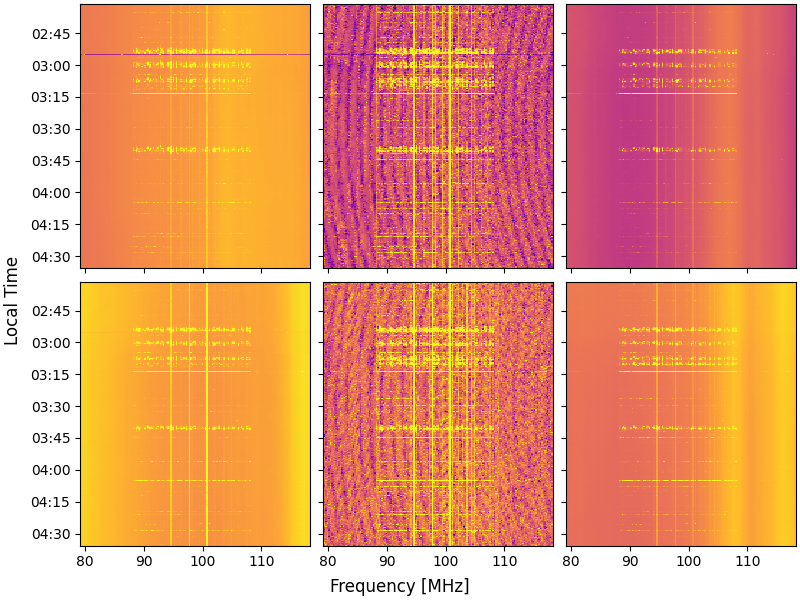

/tmp/ipykernel_65233/3898631817.py:10: RuntimeWarning: invalid value encountered in divide
  axs[i, 1].imshow(np.abs(data[k][:, 0, :, 0]+1j*data[k][:, 0, :, 1])/norm, norm=cross_ln, **kwargs)


In [18]:
fig, axs = plt.subplots(figsize=(8, 6), nrows=2, ncols=3, sharex=True, sharey=True, constrained_layout=True)
auto_ln = colors.LogNorm(vmin=1e4, vmax=1e6)
cross_ln = colors.LogNorm(vmin=1e-3, vmax=1e0)
kwargs = {"aspect": "auto", "cmap": "plasma", "extent": extent, "interpolation": "none"}
for i, k in enumerate(["02", "13"]):
    for j in range(2):
        d = np.abs(data[k[j]][:, 0, :, 0])
        axs[i, 2*j].imshow(d, norm=auto_ln, **kwargs)
    norm = np.sqrt(data[k[0]]**2 + data[k[1]]**2)[:, 0, :, 0]
    axs[i, 1].imshow(np.abs(data[k][:, 0, :, 0]+1j*data[k][:, 0, :, 1])/norm, norm=cross_ln, **kwargs)
axs[0, 0].yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.supxlabel("Frequency [MHz]")
fig.supylabel("Local Time")
plt.show()

<IPython.core.display.Javascript object>


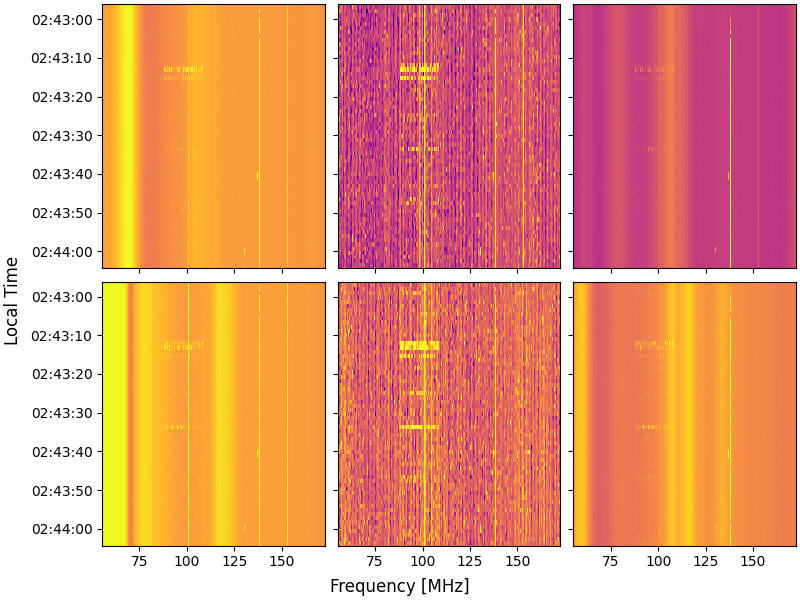

/tmp/ipykernel_65233/491571859.py:10: RuntimeWarning: invalid value encountered in divide
  axs[i, 1].imshow(np.abs(data[k][:, 0, :, 0]+1j*data[k][:, 0, :, 1])/norm, norm=cross_ln, **kwargs)


In [20]:
fig, axs = plt.subplots(figsize=(8, 6), nrows=2, ncols=3, sharex=True, sharey=True, constrained_layout=True)
auto_ln = colors.LogNorm(vmin=1e4, vmax=1e6)
cross_ln = colors.LogNorm(vmin=1e-3, vmax=1e0)
kwargs = {"aspect": "auto", "cmap": "plasma", "extent": extent, "interpolation": "none"}
for i, k in enumerate(["02", "13"]):
    for j in range(2):
        d = np.abs(data[k[j]][:, 0, :, 0])
        axs[i, 2*j].imshow(d, norm=auto_ln, **kwargs)
    norm = np.sqrt(data[k[0]]**2 + data[k[1]]**2)[:, 0, :, 0]
    axs[i, 1].imshow(np.abs(data[k][:, 0, :, 0]+1j*data[k][:, 0, :, 1])/norm, norm=cross_ln, **kwargs)
axs[0, 0].yaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.supxlabel("Frequency [MHz]")
fig.supylabel("Local Time")
plt.show()